### Get data

In [1]:
%pip install yfinance

In [2]:
import numpy as np
import pandas as pd
import os
import yfinance as yf
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.optimize import fmin
from scipy.special import lambertw
from scipy.stats import kurtosis, zscore, normaltest, norm

from sklearn.model_selection import ParameterGrid

from tensorflow import keras
from keras.utils.vis_utils import plot_model
from tqdm.keras import TqdmCallback

from gan import GAN
from preprocess import Gaussianize, rolling_window
from metrics import acf_score, le_score



In [3]:
raw_data = yf.download('^GSPC','2009-05-01','2018-12-31')

[*********************100%***********************]  1 of 1 completed


### Prepare data

/content/preprocess.py:25: RuntimeWarning: invalid value encountered in true_divide
  return np.sign(z) * np.sqrt(np.real(lambertw(delta * z ** 2)) / delta)


3.9624870434577296e-07 6
loc: 0.000000, scale: 1.000000
kurtosis: 3.000075
NormaltestResult(statistic=8.398756407809078, pvalue=0.01500490391106761)


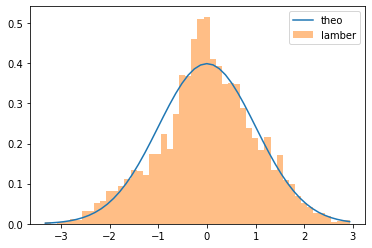

In [4]:
logret = np.diff(np.log(raw_data['Close']))
gauss = Gaussianize()
gauss.fit(logret)
u = gauss.transform(logret)

loc, scale = norm.fit(u)
print(f'loc: {loc:.6f}, scale: {scale:.6f}')
print(f'kurtosis: {kurtosis(u, fisher=False):.6f}')
print(normaltest(u))
xmin, xmax = u.min(), u.max()
x = np.linspace(xmin, xmax)
plt.plot(x, norm.pdf(x, loc, scale), label='theo')
plt.hist(u, alpha=0.5, bins=50, label='lamber', density=True)
plt.legend()
plt.show()



In [5]:
data = rolling_window(u, 127, 5)
data = np.expand_dims(data, 2)
data.shape

batch_size = 32
data = tf.cast(data, tf.float32)
dataset = tf.data.Dataset.from_tensor_slices(data).batch(batch_size)

In [6]:
latent_size = 3
hidden_size = 80
output_size = 1
d_train_steps = 5


### Functions

In [7]:
def build_model(params):
  gan = GAN(latent_size, hidden_size, output_size, 
            params['d_train_steps'], params['gp_weight'])

  g_optimizer = keras.optimizers.Adam(learning_rate=params['g_lr'], 
                                      beta_1=params['g_b1'], 
                                      beta_2=params['g_b2'])
  d_optimizer = keras.optimizers.Adam(learning_rate=params['d_lr'], 
                                      beta_1=params['d_b1'], 
                                      beta_2=params['d_b1'])

  gan.compile(
      d_optimizer=g_optimizer,
      g_optimizer=d_optimizer,
      loss_fn=keras.losses.BinaryCrossentropy(),
      use_reduce_loss=params['use_reduce_loss']
  )
  return gan


def get_train_losses(model, epochs):
  history = model.fit(dataset, epochs=epochs, 
                    verbose=0, 
                    callbacks=[TqdmCallback(verbose=1)])
  return {"g_loss": history.history['g_loss'][-1], 
          "d_loss": history.history['d_loss'][-1]}


def average_model_train(params, n_steps=10):
  g_loss, d_loss = 0, 0
  for _ in range(n_steps):
    model = build_model(params)
    res = get_train_losses(model, 15)
    g_loss += res["g_loss"]
    d_loss += res["d_loss"]

  return {"g_loss": g_loss / n_steps, 
          "d_loss": d_loss / n_steps}

def grid_search(param_set, n_steps=10):
  hist = {}
  for i, params in enumerate(param_set):
    losses = average_model_train(params, n_steps)
    hist[f"params_{i}"] = {"params": params, 
                        "g_loss": losses["g_loss"],
                        "d_loss": losses["d_loss"]}
    print(f"params_{i}: g_loss = {losses['g_loss']}, d_loss = {losses['d_loss']}")
  return hist

In [ ]:
def plot_results(fake):
  loc, scale = norm.fit(fake)
  print(f'loc: {loc:.6f}, scale: {scale:.6f}')
  print(f'kurtosis: {kurtosis(fake, fisher=False):.6f}')
  print(f'kurtosis: {kurtosis(u, fisher=False):.6f}')
  print(normaltest(fake))
  plt.figure(figsize=(10, 6))
  plt.ylabel('Density')
  plt.hist([fake, u], bins=50, label=['fake', 'real'], density=True)
  plt.legend()
  plt.show()

In [20]:
def lagged_returns(returns, lag):
  return np.diff(returns, lag)


def get_metrics_for_model(model, data, M=500, T=2432, S=250, lags=[1,5,20,100]):
  """T: number of samples per path
     M: number of path to generate"""
  results = {}
  fake_set = []
  for _ in range(M):
    latent_noise = tf.random.normal(shape=(1, T, 3))
    fake_set += [model.generator(latent_noise).numpy().reshape(T)]

  fake_set = np.array(fake_set)

  for l in lags:
    hist_lagged = lagged_returns(data, l)
    gen_lagged = lagged_returns(fake_set.mean(axis=1), l)
    results[f'emd_{l}'] = emd_score(hist_lagged, gen_lagged)
  

  funcs = [None, np.abs, lambda x: x**2]
  fname = ['id', 'abs', 'sq']
  for f, name in zip(funcs, fname):
    results[f'acf_{name}'] = acf_score(data, fake_set, S, func=f)

  results['le'] = le_score(data, fake_set, S)

  return results

In [8]:
def train_model_with_params(params, name, epochs=10, T=2433, plot=True):
  gan = GAN(latent_size, hidden_size, output_size, 
            params['d_train_steps'], params['gp_weights'],
            tcn_skip=params['tcn_skip'], block_skip=params['block_skip'])

  if params['opt'] == 'adam':
    g_optimizer = keras.optimizers.Adam(learning_rate=params['g_lr'], 
                                        beta_1=params['g_b1'], 
                                        beta_2=params['g_b2'])
    d_optimizer = keras.optimizers.Adam(learning_rate=params['d_lr'], 
                                        beta_1=params['g_b1'], 
                                        beta_2=params['g_b2'])
  else:
    g_optimizer = keras.optimizers.RMSprop(params['g_lr'])
    d_optimizer = keras.optimizers.RMSprop(params['d_lr'])

  gan.compile(
    d_optimizer=g_optimizer,
    g_optimizer=d_optimizer,
    loss_fn=keras.losses.BinaryCrossentropy(),
    use_reduce_loss=params['use_reduce_loss']
  )

  checkpoint_filepath = f'./{name}'
  model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
      filepath=checkpoint_filepath,
      save_weights_only=True,
      monitor='g_loss',
      mode='max',
      save_best_only=True)

  history = gan.fit(dataset, epochs=epochs, verbose=0, 
                    callbacks=[TqdmCallback(verbose=1), model_checkpoint_callback])
  if plot:
    latent_noise = tf.random.normal(shape=(1, T, 3))
    fake = gan.generator(latent_noise).numpy().reshape(T)
    plot_results(fake)
  return gan

### Grid search

In [9]:
# param_set_binary = {
#     'd_train_steps': [5], 'gp_weight': [0], 'use_reduce_loss': [False],
#     'g_lr': np.linspace(0.0001, 0.0002, 5), 'g_b1': [0], 'g_b2': [0.9],
#     'd_lr': np.linspace(0.0001, 0.0002, 5), 'd_b1': [0], 'd_b2': [0.9],
# }

# param_grid = list(ParameterGrid(param_set_binary))
# hist = grid_search(param_grid, 1)

### Adam, with gradient penalty, TCN skips

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

loc: -0.048081, scale: 0.919366
kurtosis: 2.905013
kurtosis: 3.000075
NormaltestResult(statistic=8.144206663180345, pvalue=0.017041506845504314)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


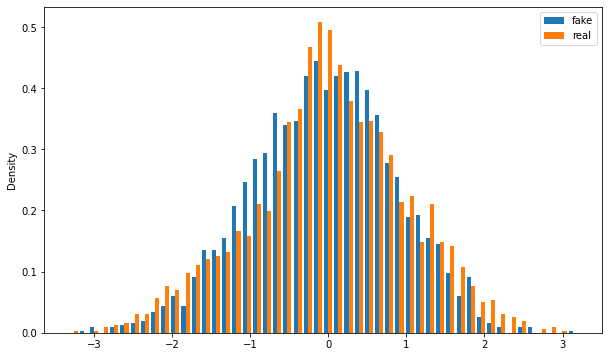

In [10]:
adam_binary_tcn_gp = {
    'd_train_steps': 5, 'gp_weights': 1, 'use_reduce_loss': False,
    'g_lr': 0.0001, 'g_b1': 0.5, 'g_b2': 0.9,
    'd_lr': 0.0001, 'd_b1': 0.5, 'd_b2': 0.9,
    'tcn_skip': True, 'block_skip': False,
    'opt': 'adam'
}

adam_binary_tcn_gp = train_model_with_params(adam_binary_tcn_gp, 'adam_binary_tcn_gp')

### Adam, with gradient penalty, residual skips

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

loc: 0.067034, scale: 0.871573
kurtosis: 2.668678
kurtosis: 3.000075
NormaltestResult(statistic=25.451454417945186, pvalue=2.9736297628839187e-06)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


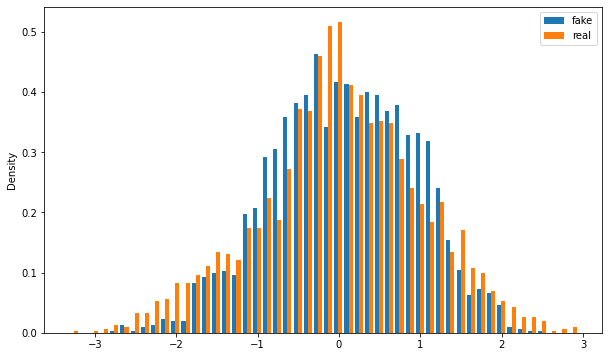

In [11]:
adam_binary_res_gp = {
    'd_train_steps': 5, 'gp_weights': 0.01, 'use_reduce_loss': False,
    'g_lr': 0.0002, 'g_b1': 0.5, 'g_b2': 0.9,
    'd_lr': 0.0001, 'd_b1': 0.5, 'd_b2': 0.9,
    'tcn_skip': False, 'block_skip': True,
    'opt': 'adam'
}

adam_binary_res_gp = train_model_with_params(adam_binary_res_gp, 'adam_binary_res_gp')

### RMSProp, with gradient penalty, residual skips

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

loc: 0.449575, scale: 0.986332
kurtosis: 3.714343
kurtosis: 3.000075
NormaltestResult(statistic=33.04563511274139, pvalue=6.671623192928971e-08)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


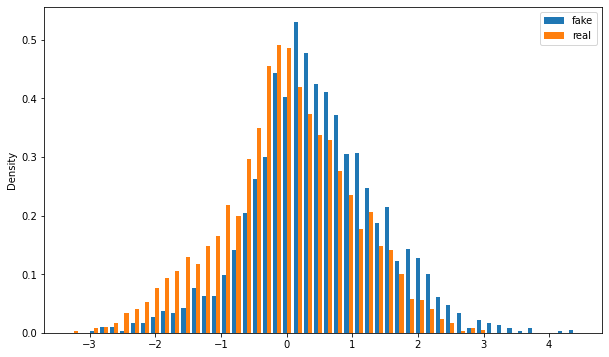

In [12]:
rms_binary_res_gp = {
    'd_train_steps': 5, 'gp_weights': 1, 'use_reduce_loss': False,
    'g_lr': 0.001, 'd_lr': 0.001,
    'tcn_skip': False, 'block_skip': True,
    'opt': 'rms'
}

rms_binary_res_gp = train_model_with_params(rms_binary_res_gp, 'rms_binary_res_gp')

### RMSProp, with gradient penalty, TCN skips

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

loc: -0.688913, scale: 0.971313
kurtosis: 4.338912
kurtosis: 3.000075
NormaltestResult(statistic=200.0139920098938, pvalue=3.694141132017885e-44)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


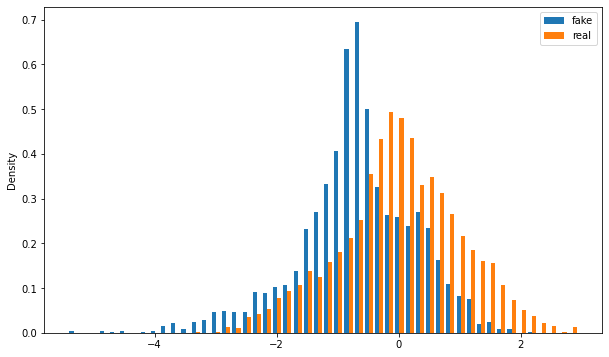

In [22]:
rms_binary_tcn_gp = {
    'd_train_steps': 5, 'gp_weights': 1, 'use_reduce_loss': False,
    'g_lr': 0.001, 'd_lr': 0.001,
    'tcn_skip': True, 'block_skip': False,
    'opt': 'rms'
}

rms_binary_tcn_gp = train_model_with_params(rms_binary_tcn_gp, 'rms_binary_tcn_gp')

### Why no try both skips?

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

loc: 0.005990, scale: 0.871566
kurtosis: 2.828340
kurtosis: 3.000075
NormaltestResult(statistic=20.571266412997645, pvalue=3.411978261678061e-05)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


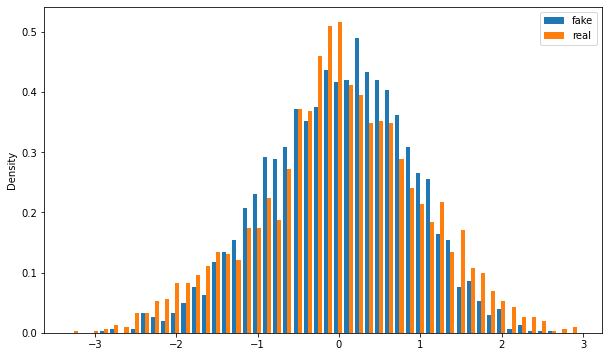

In [16]:
adam_binary_doubleskip_gp = {
    'd_train_steps': 5, 'gp_weights': 1, 'use_reduce_loss': False,
    'g_lr': 0.0001, 'g_b1': 0.5, 'g_b2': 0.9,
    'd_lr': 0.0001, 'd_b1': 0.5, 'd_b2': 0.9,
    'tcn_skip': True, 'block_skip': True,
    'opt': 'adam'
}

adam_binary_doubleskip_gp = train_model_with_params(adam_binary_doubleskip_gp, 'adam_binary_doubleskip_gp')

### Wasserstein 

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

loc: 0.015116, scale: 0.857692
kurtosis: 2.755269
kurtosis: 3.000075
NormaltestResult(statistic=19.249335829147746, pvalue=6.607844807508517e-05)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


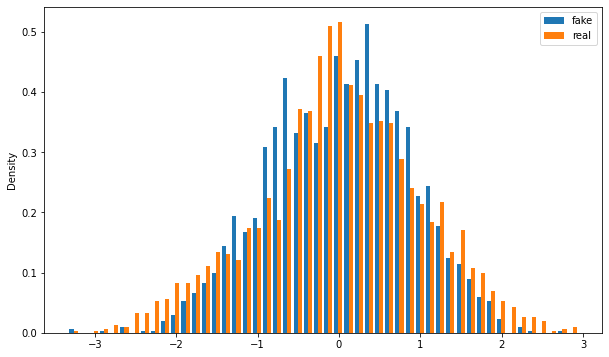

In [18]:
adam_reduce_blockskip_gp = {
    'd_train_steps': 5, 'gp_weights': 1, 'use_reduce_loss': True,
    'g_lr': 0.0001, 'g_b1': 0.5, 'g_b2': 0.9,
    'd_lr': 0.0001, 'd_b1': 0.5, 'd_b2': 0.9,
    'tcn_skip': False, 'block_skip': True,
    'opt': 'adam'
}

adam_reduce_blockskip_gp = train_model_with_params(adam_reduce_blockskip_gp, 'adam_reduce_blockskip_gp')

In [21]:
get_metrics_for_model(adam_reduce_blockskip_gp, u)

{'acf': {'abs': 1.0697112460322225,
  'id': 0.36102369034747095,
  'sq': 1.1254390954216709},
 'emd': {},
 'le': 0.4371245447871897}

In [ ]:
get_metrics_for_model(adam_binary_doubleskip_gp, u)

In [ ]:
get_metrics_for_model(rms_binary_tcn_gp, u)

In [ ]:
get_metrics_for_model(rms_binary_res_gp, u)

In [ ]:
get_metrics_for_model(adam_binary_res_gp, u)

In [ ]:
get_metrics_for_model(adam_binary_tcn_gp, u)